In [17]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
import math
from collections import defaultdict

import seaborn as sns

from downstream.signals.signal_r2_permutation_test import process, collect_paths
from downstream.signals.signals_util import extract_normalization, extract_datatype
import downstream.bed_metrics as bm

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [18]:
# simulations = 6
simulations = 100001
threads = 8
clear_cache = False

In [19]:
def walk_folders(path):
    yield path
    for f in path.iterdir():
        if f.is_dir():
            yield from walk_folders(f)

# Histone modifications

In [20]:
datatype_loci = defaultdict(list)
datatype_loci["meth"] = [
    "ucsc_cpgIslandExt.hg19", 
    "cpg_minavcov10_complex_4outliers.narrow.adjusted.regions.filtered",
    "washu_german_rrbs_filtered_dmrs_all_10.hg19"
]
datatype_loci["H3K36me3"] = ["coding_transcript", "noncoding_transcript"]

hist_to_chromhmm_states = {
    "H3K4me1": ["8_EnhG2", "9_EnhA1"],
    "H3K4me3": ["1_TssA", "2_TssFlnk"],
    "H3K27ac": ["1_TssA", "3_TssFlnkU"],
    "H3K36me3": ["5_Tx", "7_EnhG1", "8_EnhG2"],
    "H3K27me3": ["14_TssBiv", "15_EnhBiv","16_ReprPC"],
}
for hist, states in hist_to_chromhmm_states.items():
    for s in states:
        for vers in ["encsr511wof", "encsr907lcd"]:
            datatype_loci[hist].append("cd14_{}_chromhmm18.hg19.{}".format(vers, s))
        
for dt in ["H3K4me1", "H3K4me3", "H3K27ac", "H3K36me3", "H3K27me3", "meth"]:
    loci = datatype_loci[dt]
    loci.append("random1000x10000")
    loci.append("hg19_100000")
    if dt.startswith("H"):
        loci.append("coding_tss[-2000..2000]")
        loci.append("{}_zinbra_median_consensus".format(dt))
        loci.append("{}_zinbra_weak_consensus".format(dt))
        
signals_root = Path("/mnt/stripe/bio/experiments/signal_experiment")

In [21]:
folders = []
for dt, loci in datatype_loci.items():
    dt_root = signals_root / dt
    if dt_root.exists():
        folders.extend(f for f in walk_folders(dt_root) if f.name in loci)
        
paths = [p for folder in folders for p in collect_paths(folder)]
print("Paths: ", len(paths))
print("Loci folders: {}".format(len(folders)), *[str(p) for p in folders], sep="\n  ")

Paths:  410
Loci folders: 51
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/random1000x10000
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/H3K36me3_zinbra_weak_consensus
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/coding_tss[-2000..2000]
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/coding_transcript
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/noncoding_transcript
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/cd14_encsr511wof_chromhmm18.hg19.5_Tx
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/cd14_encsr511wof_chromhmm18.hg19.7_EnhG1
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/cd14_encsr511wof_chromhmm18.hg19.8_EnhG2
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/H3K36me3_zinbra_median_consensus
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/cd14_encsr907lcd_chromhm

In [22]:
output_path = signals_root / "validate.norms.permutation_r2.{}.csv".format(simulations)
output_path

print(str(output_path), "[exists]" if output_path.exists() else "[not exists]")

/mnt/stripe/bio/experiments/signal_experiment/validate.norms.permutation_r2.100001.csv [exists]


In [23]:
# if not output_path.exists():
#     process(paths, str(output_path), seed=100, simulations=simulations, threads=threads)
process(paths, str(output_path), seed=100, simulations=simulations, threads=threads)
print("Results file: ", str(output_path))

--- [1 / 410] -----------
Process: /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/H3K36me3_zinbra_weak_consensus/H3K36me3_zinbra_weak_consensus_raw.tsv
mean = 0.9748608054725791, median = 0.989306650667338, [min, max] = [0.3449276959680645, 0.99978153457729], [2%, 98%] = [0.8507361451448849, 0.9993838993301656], wd = 0.050551482130665404
--- [2 / 410] -----------
Process: /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/H3K36me3_zinbra_weak_consensus/H3K36me3_zinbra_weak_consensus_rpm.tsv
mean = 0.9900008018056708, median = 0.9946198039585332, [min, max] = [0.8418523009729808, 0.9997755115444028], [2%, 98%] = [0.9503583784308288, 0.9995853933461168], wd = 0.016069270939898433
--- [3 / 410] -----------
Process: /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/H3K36me3_zinbra_weak_consensus/H3K36me3_zinbra_weak_consensus_fripm.tsv
mean = 0.9978561118386422, median = 0.9985636527727038, [min, max] = [0.9790350603436462, 0.9997727203323984], [2%, 98%] = [0.9

KeyboardInterrupt: 

In [30]:
df = pd.DataFrame.from_csv(output_path, index_col=None)
df["loci"] = [Path(f).name for f in df["file"]]
print("Shape:", df.shape)
df.head(10)

Shape: (184, 8)


,modification,file,normalization,mean,median,p2,wdist,loci
0,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_minus_full,0.990798,0.992533,0.971145,0.011196,H3K27ac_zinbra_median_consensus
1,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_reads_effective_cpm,0.993033,0.994020,0.981716,0.008081,H3K27ac_zinbra_median_consensus
2,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_reads_full_cpm,0.992997,0.994009,0.981169,0.008150,H3K27ac_zinbra_median_consensus
3,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,fripm,0.992335,0.993411,0.979835,0.008830,H3K27ac_zinbra_median_consensus
4,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,fripz,0.993390,0.994255,0.983253,0.007572,H3K27ac_zinbra_median_consensus
5,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,raw,0.934545,0.972257,0.613416,0.131849,H3K27ac_zinbra_median_consensus
6,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,rawz,0.994188,0.994954,0.985193,0.006648,H3K27ac_zinbra_median_consensus
7,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,rpkm,0.515948,0.761903,-1.487426,0.910655,H3K27ac_zinbra_median_consensus
8,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,rpm,0.932810,0.969653,0.613166,0.133050,H3K27ac_zinbra_median_consensus
9,H3K27ac,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_minus_full,0.991755,0.993048,0.978329,0.009591,H3K27ac_zinbra_weak_consensus


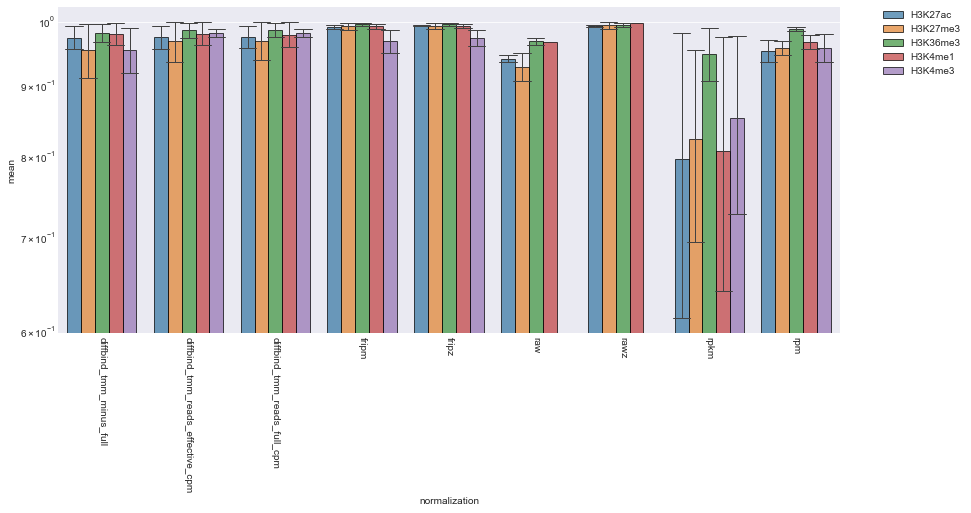

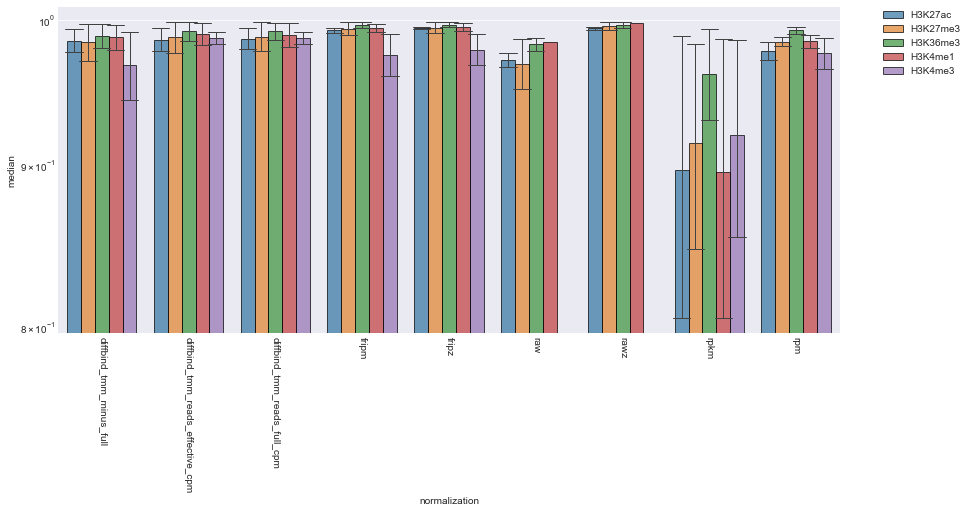

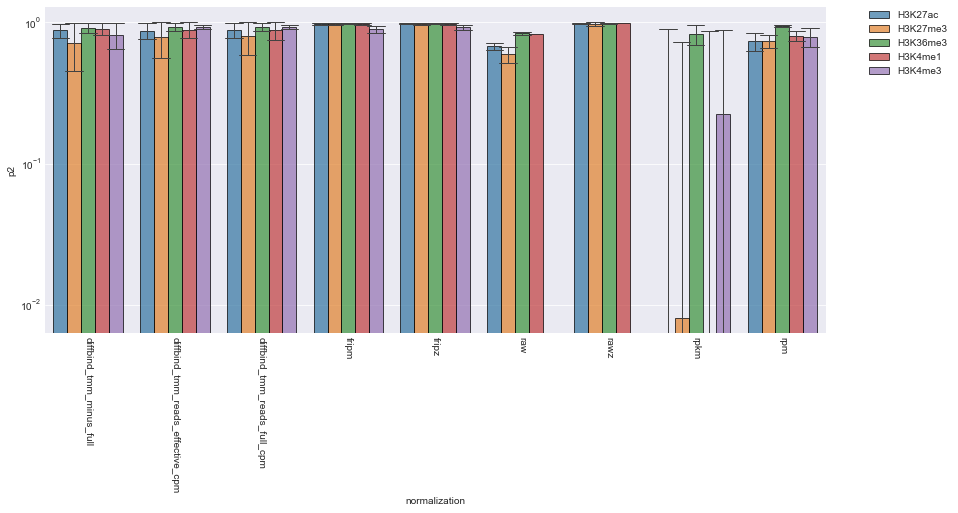

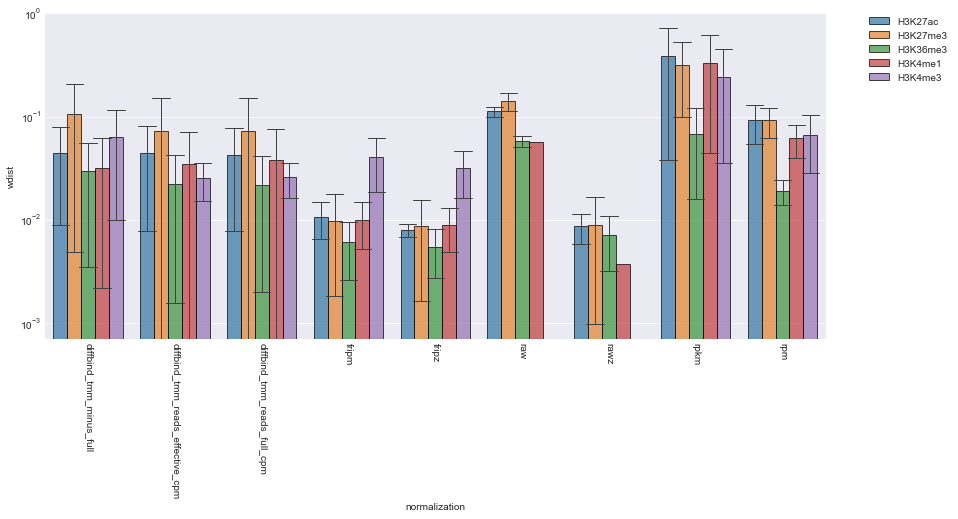

In [31]:
for metric in ["mean", "median", "p2", "wdist"]:
    plt.figure(figsize=(14, 6))
    g = sns.barplot(data=df, y=metric, x="normalization",
                    hue="modification", #order=sorted(datatype_loci.keys()),
                    ci="sd", capsize=.2, errwidth=1, # error bars
                    #color="lightgray", 
                    alpha=0.7,
                    edgecolor="black")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    g.set_yscale('log')
    plt.xticks(rotation=-90)
    plt.show()

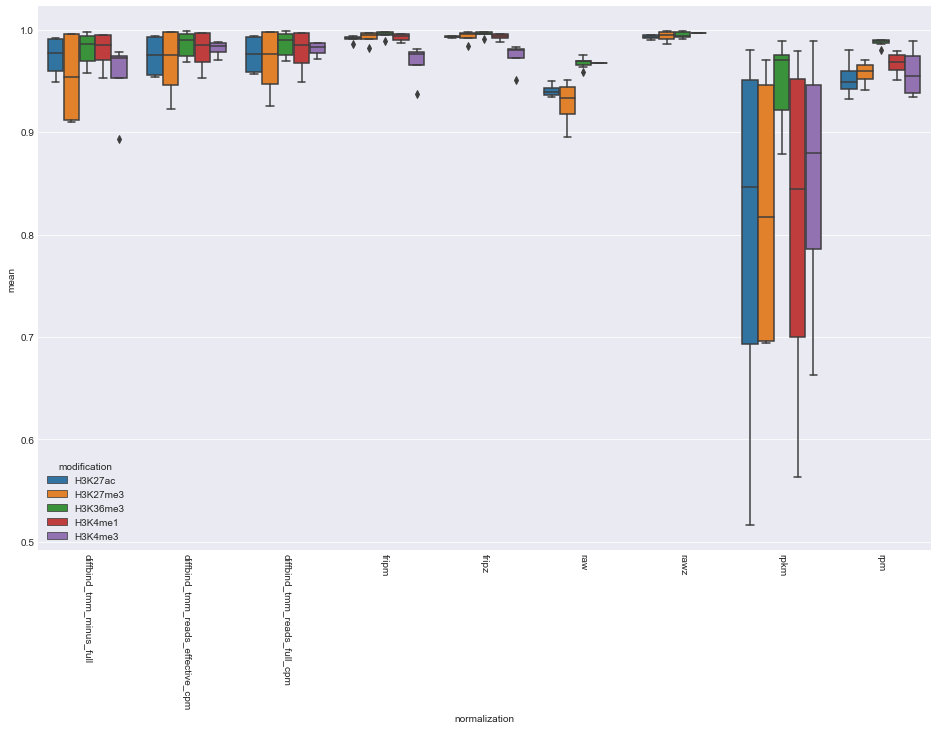

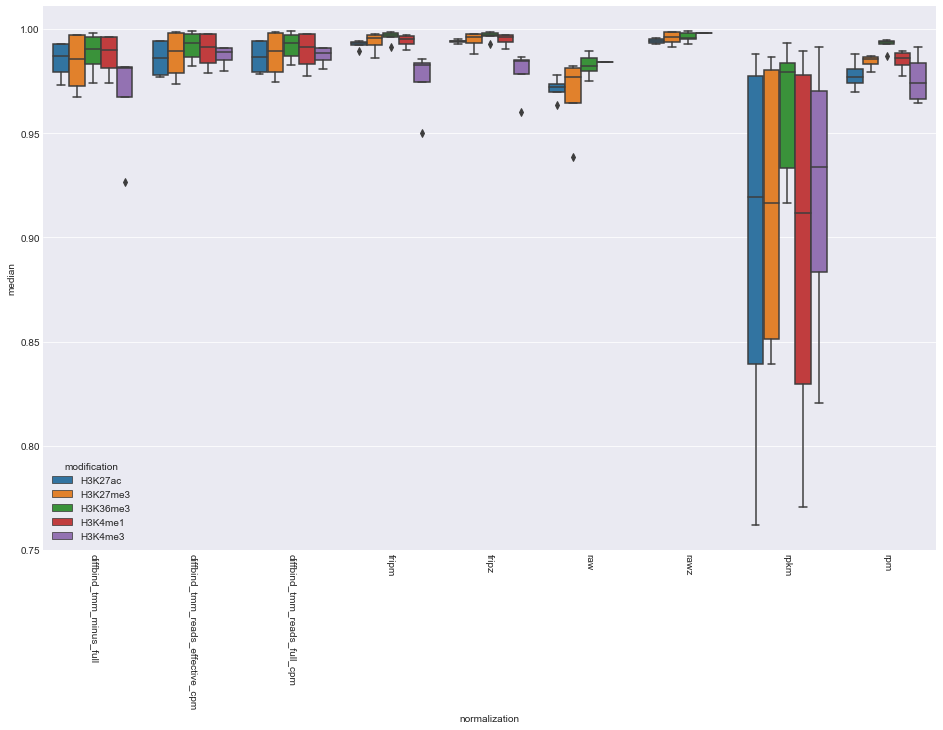

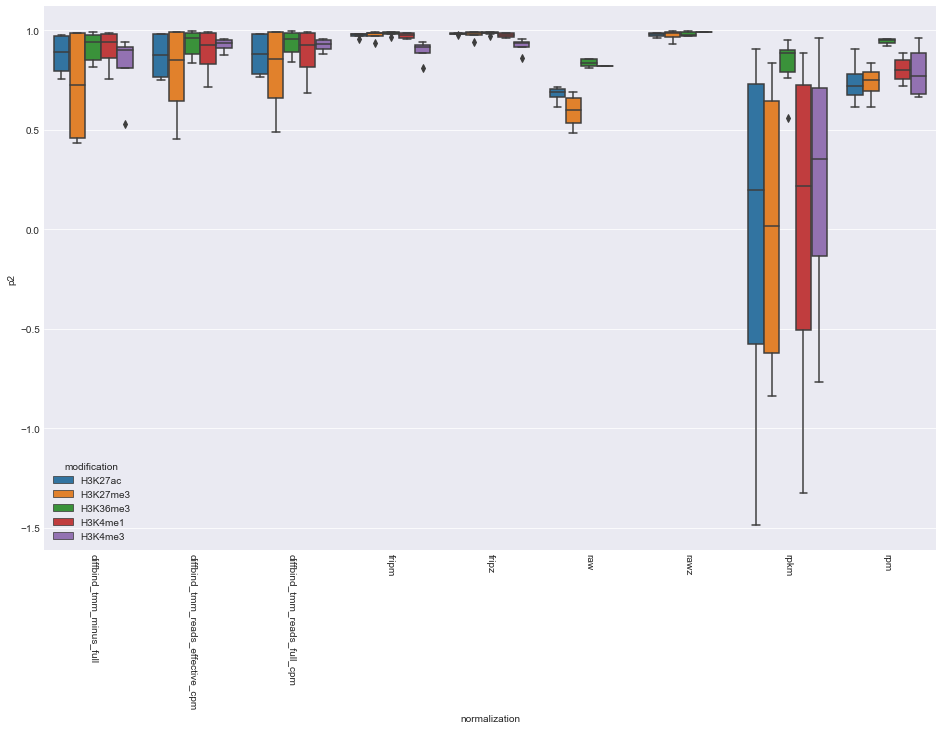

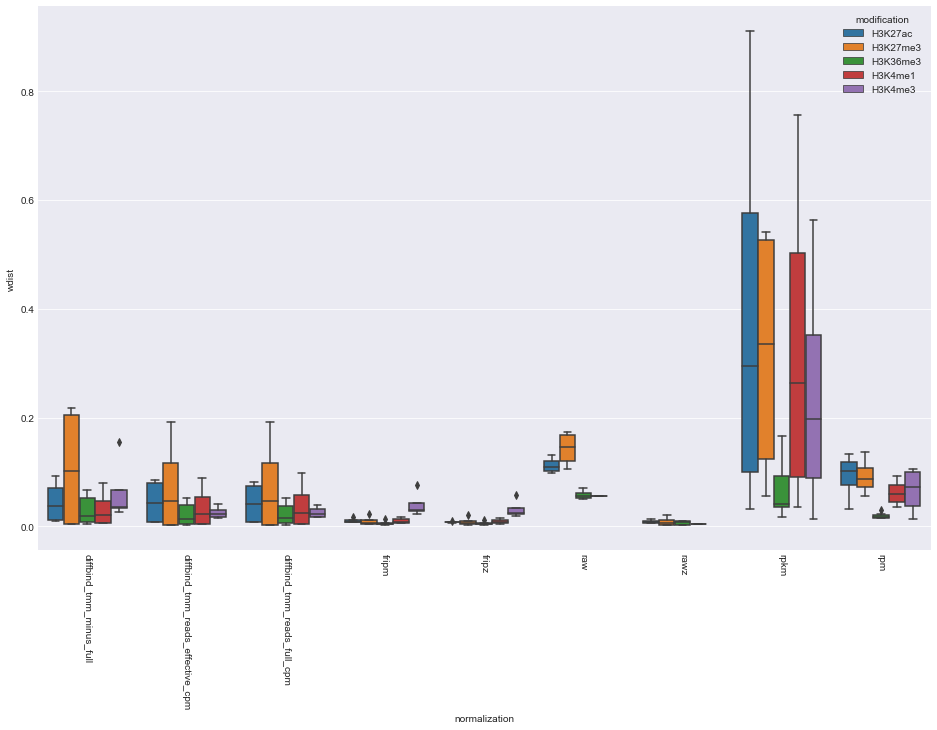

In [32]:
for metric in ["mean", "median", "p2", "wdist"]:
    plt.figure(figsize=(16, 10))
    ax = sns.boxplot(data=df, y=metric, hue="modification", x="normalization")
    plt.xticks(rotation=-90)
    plt.show()

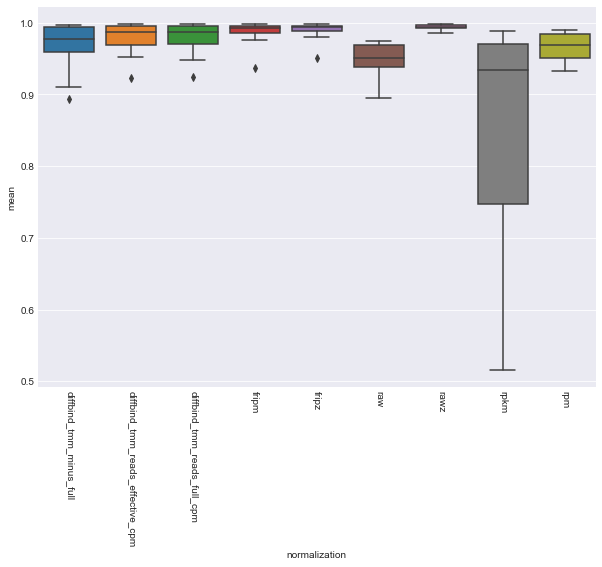

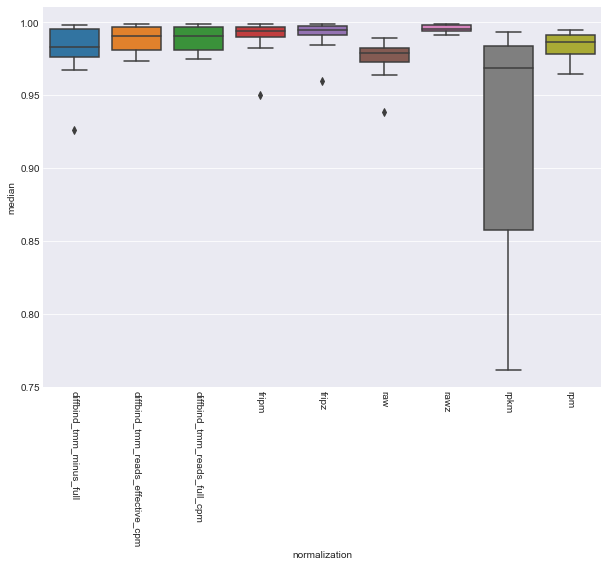

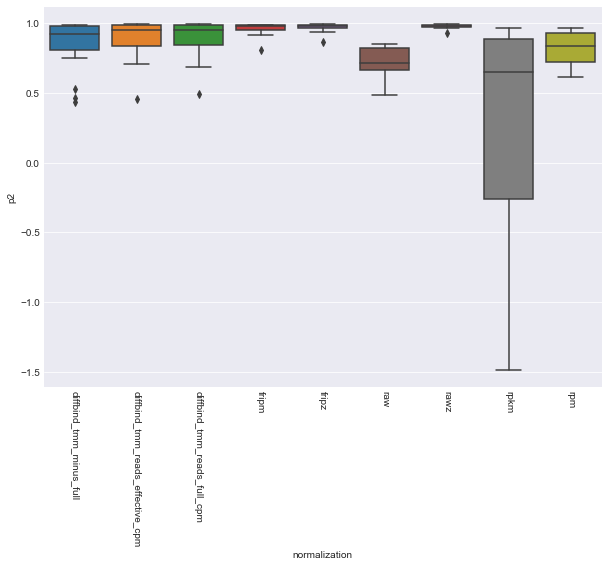

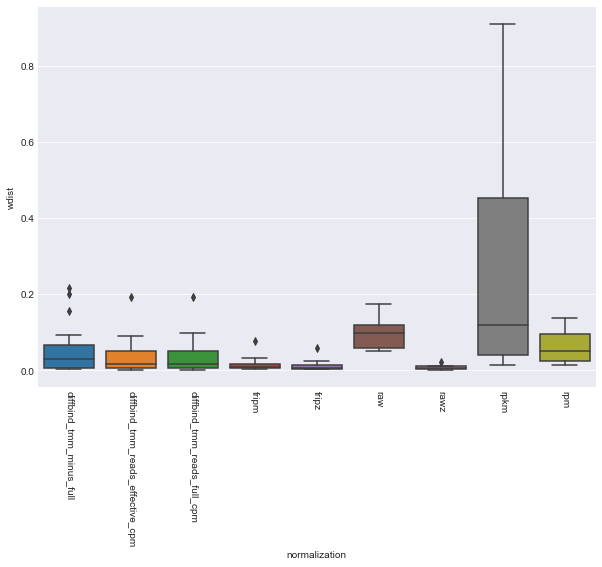

In [33]:
for metric in ["mean", "median", "p2", "wdist"]:
    plt.figure(figsize=(10, 7))
    ax = sns.boxplot(data=df[df.modification != "meth"], 
                     y=metric, x="normalization")
    plt.xticks(rotation=-90)
    plt.show()

In [34]:
# plt.figure(figsize=(20,10))
# g = sns.boxplot(data=df, y="mean", x="modification", hue="normalization")
# plt.show()

/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


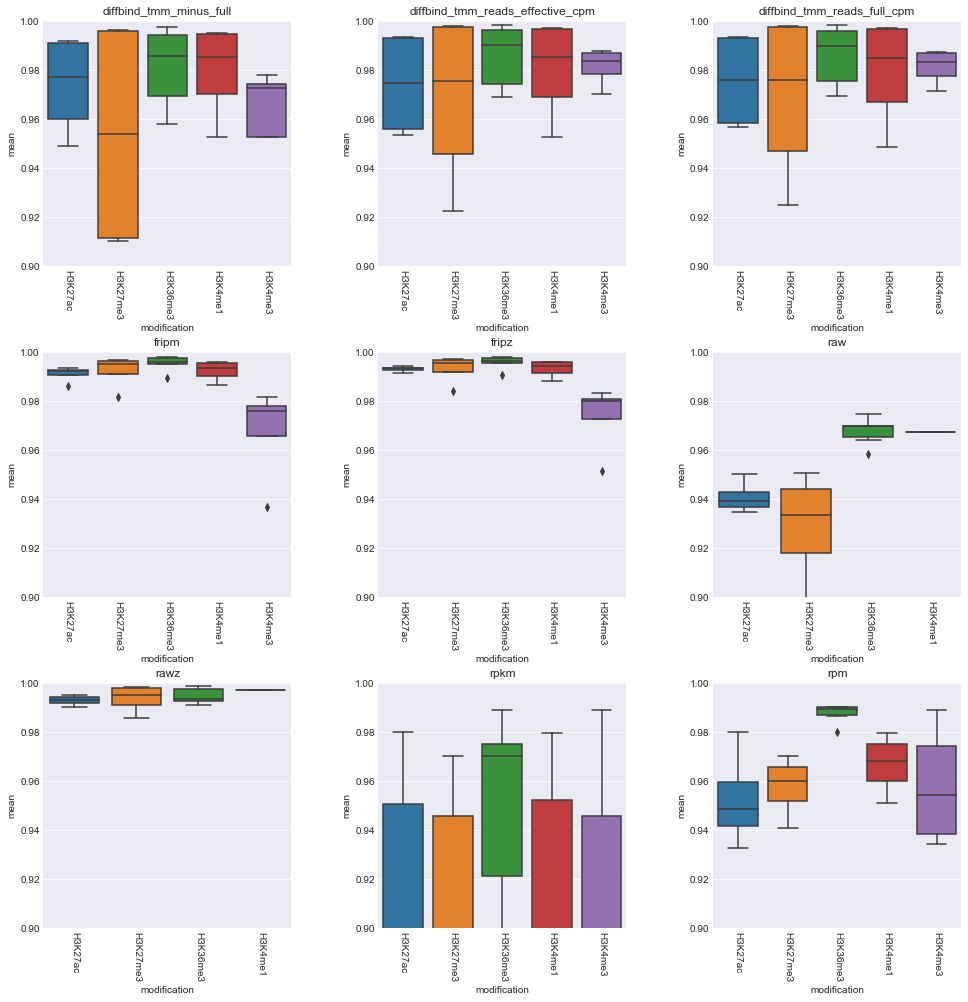

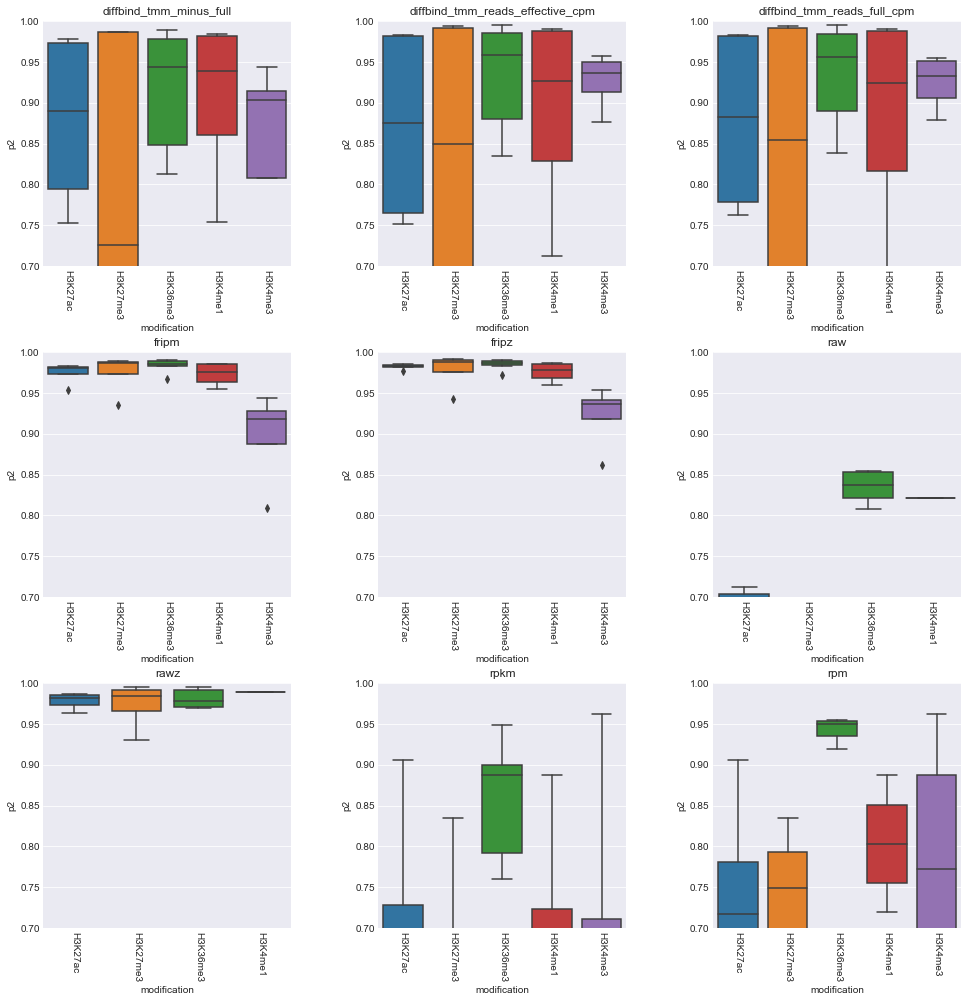

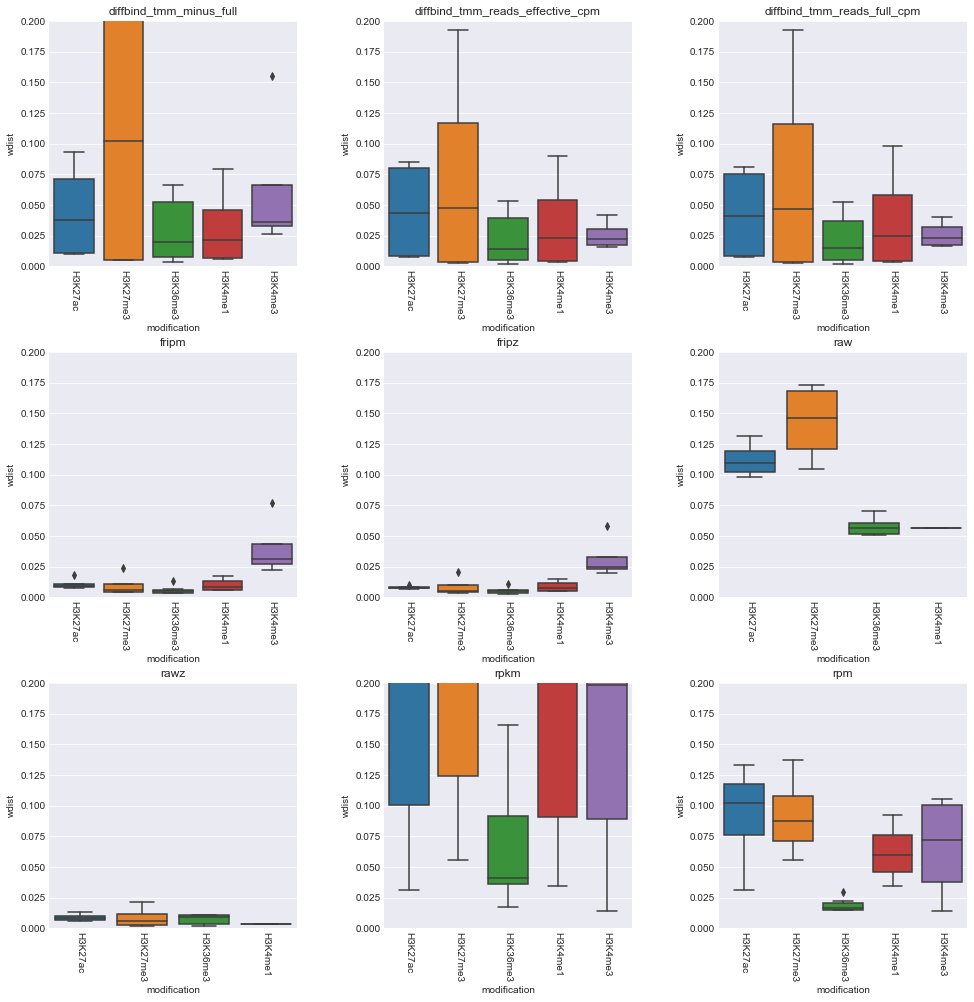

In [35]:
norms = sorted(set(df["normalization"]))
n_subplots = math.ceil(np.sqrt(len(norms)))
for metric, ylim in [("mean", (0.9, 1.0)), ("p2", (0.7, 1.0)), ("wdist", (0, 0.2))]:
    plt.figure(figsize=(n_subplots*5, n_subplots*5))
    
    for i, norm in enumerate(norms, 1):
        ax = plt.subplot(n_subplots, n_subplots, i)
        g = sns.boxplot(data=df[df["normalization"] == norm], y=metric, x="modification",
                        ax=ax)
        for item in g.get_xticklabels():
            item.set_rotation(-90)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.set_title(norm)
        ax.set_ylim(ylim)
        
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
    plt.show()


In [41]:
df[df.modification == "H3K4me3"]

,modification,file,normalization,mean,median,p2,wdist,loci
156,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_minus_full,0.972965,0.981297,0.905154,0.035180,H3K4me3_zinbra_median_consensus
157,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_reads_effective_cpm,0.980822,0.986923,0.925206,0.026045,H3K4me3_zinbra_median_consensus
158,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_reads_full_cpm,0.979361,0.986483,0.914959,0.028732,H3K4me3_zinbra_median_consensus
159,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,fripm,0.976828,0.982678,0.922517,0.029146,H3K4me3_zinbra_median_consensus
160,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,fripz,0.979716,0.984239,0.937479,0.024725,H3K4me3_zinbra_median_consensus
161,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,rpkm,0.662475,0.820556,-0.766640,0.563287,H3K4me3_zinbra_median_consensus
162,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,rpm,0.934276,0.964363,0.662164,0.105136,H3K4me3_zinbra_median_consensus
163,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_minus_full,0.972724,0.981789,0.901450,0.036353,H3K4me3_zinbra_weak_consensus
164,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_reads_effective_cpm,0.986791,0.990766,0.948002,0.017910,H3K4me3_zinbra_weak_consensus
165,H3K4me3,/mnt/stripe/bio/experiments/signal_experiment/...,diffbind_tmm_reads_full_cpm,0.987063,0.990915,0.949453,0.017426,H3K4me3_zinbra_weak_consensus


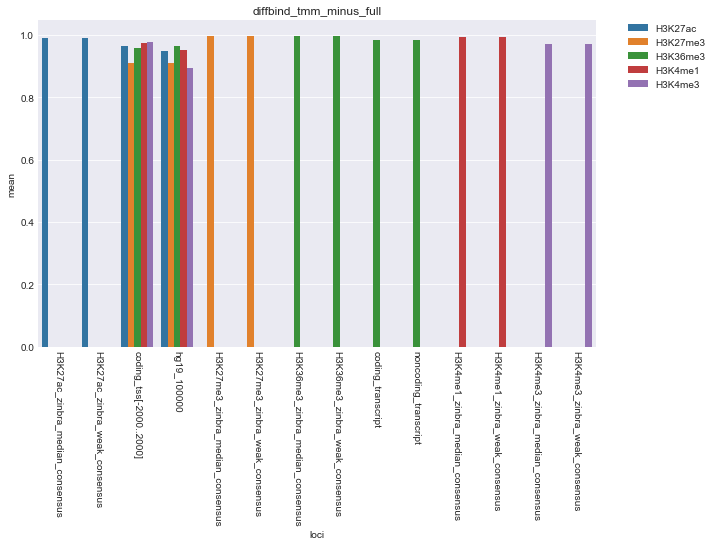

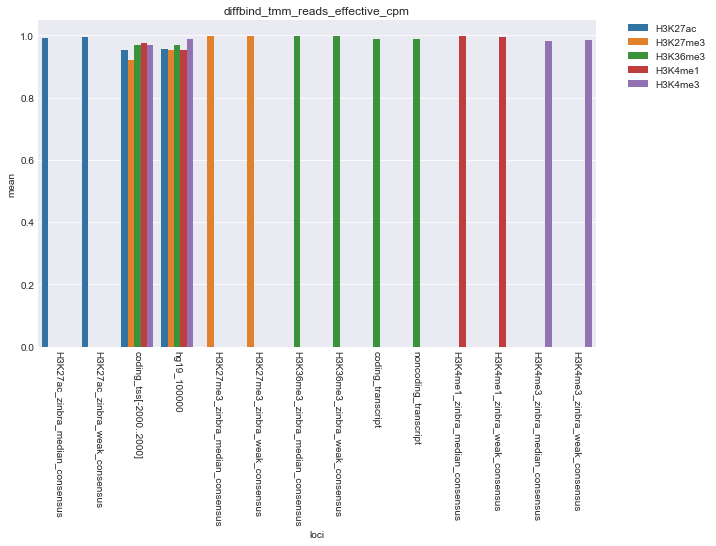

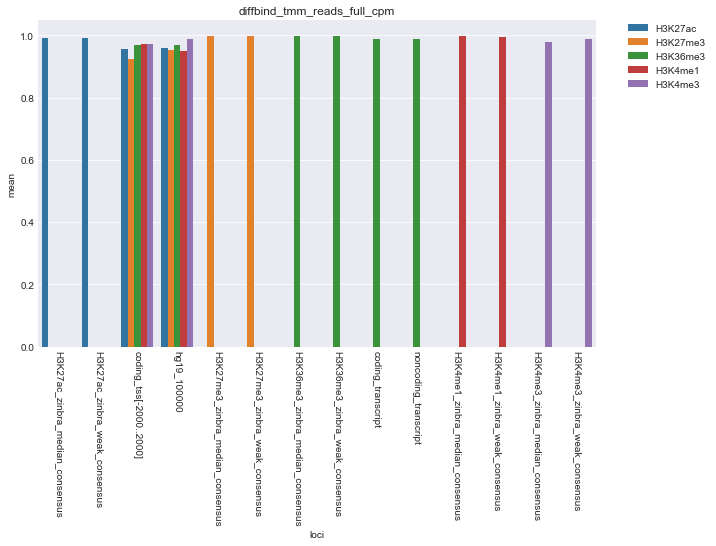

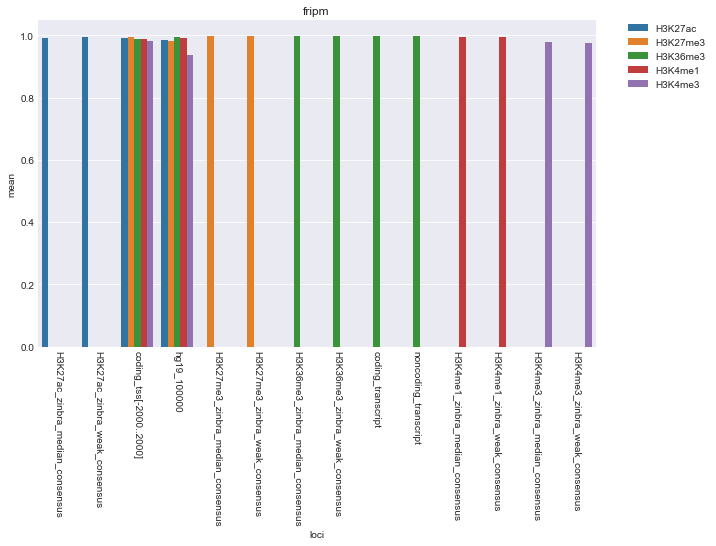

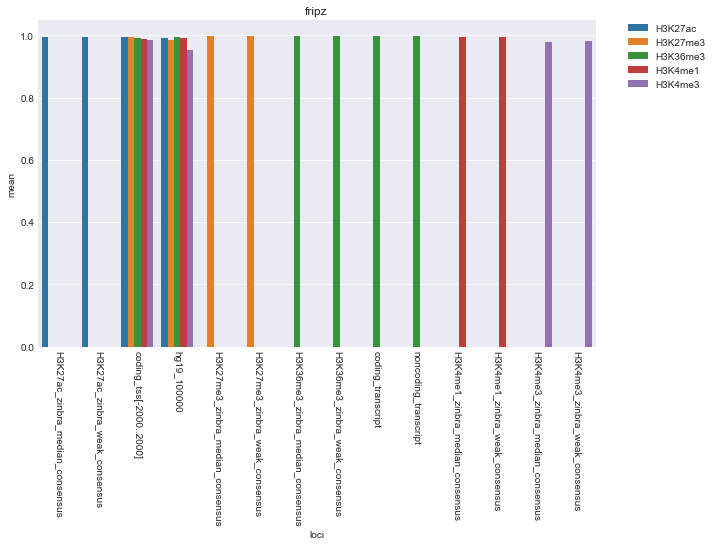

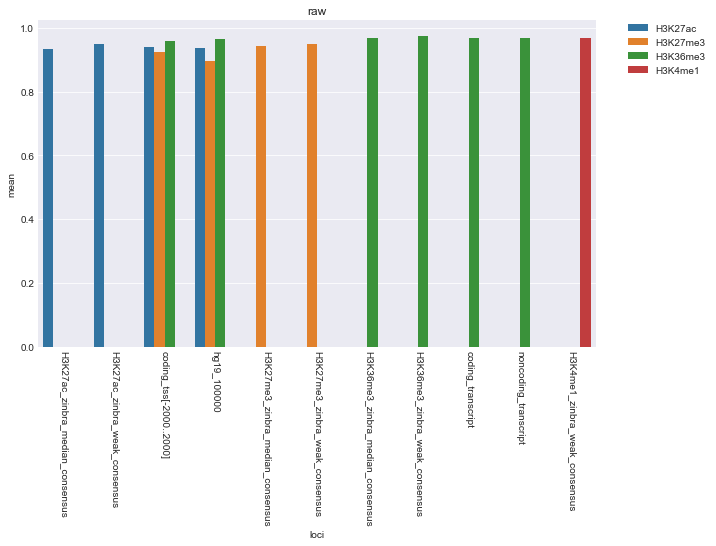

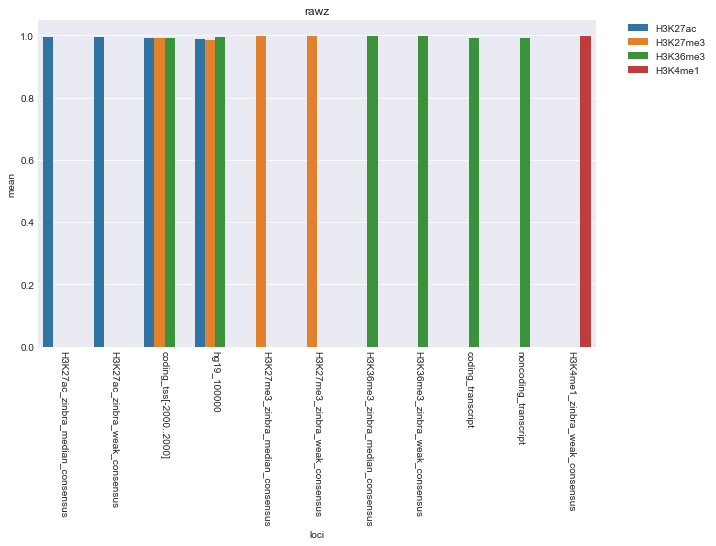

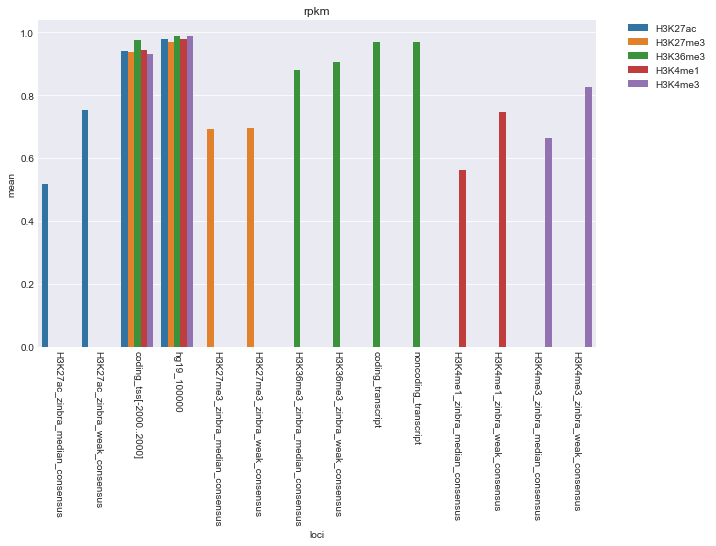

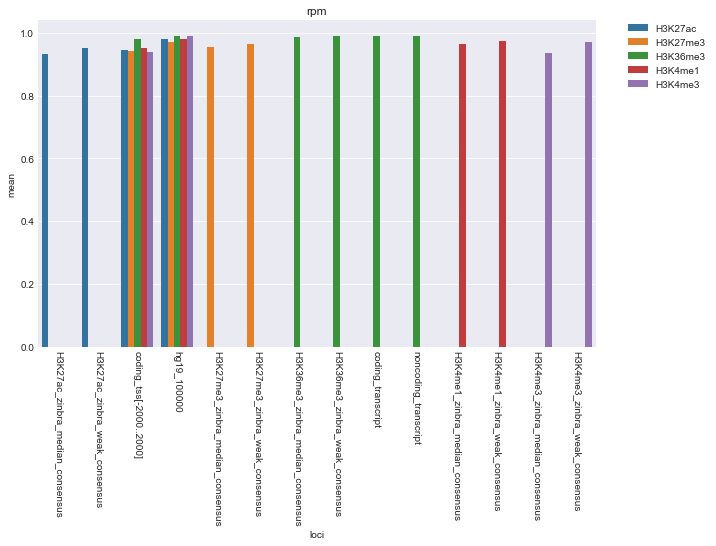

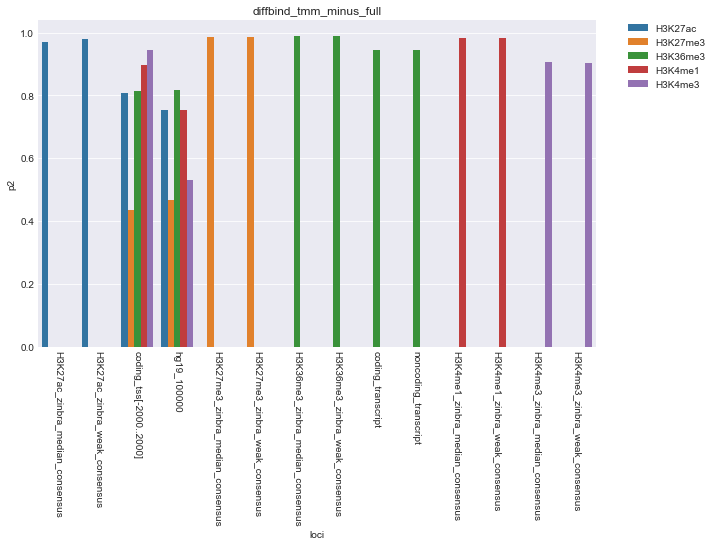

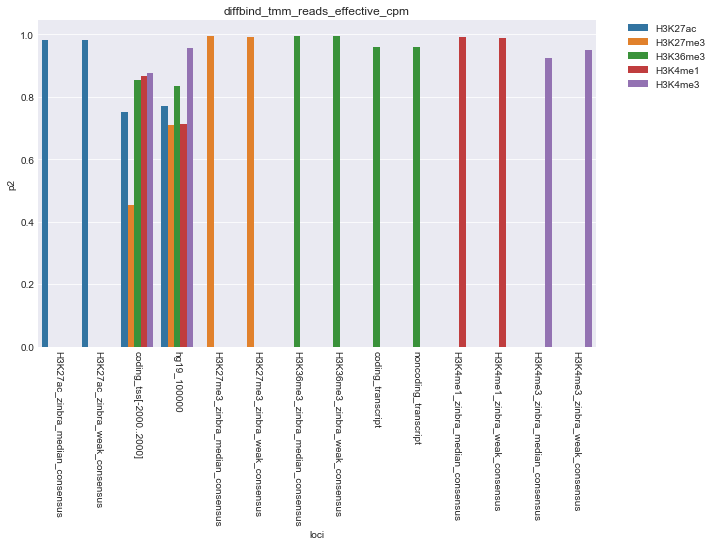

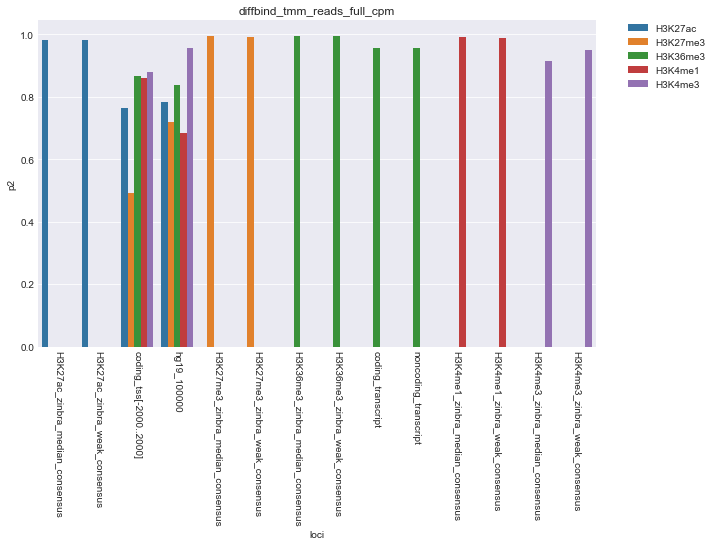

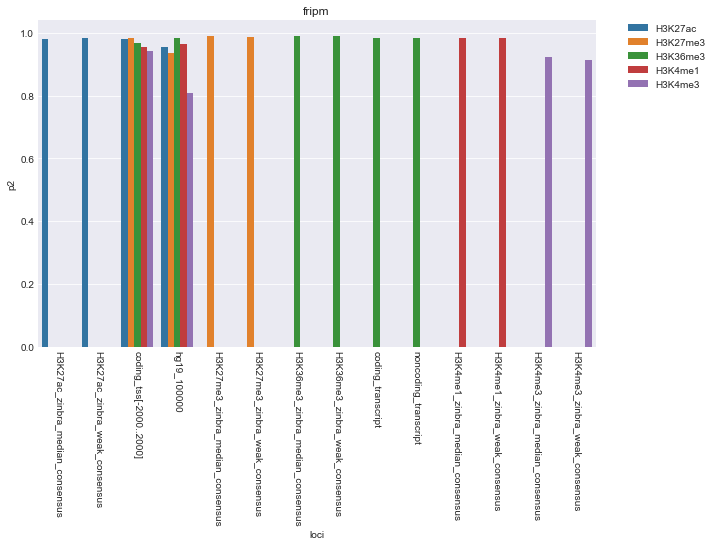

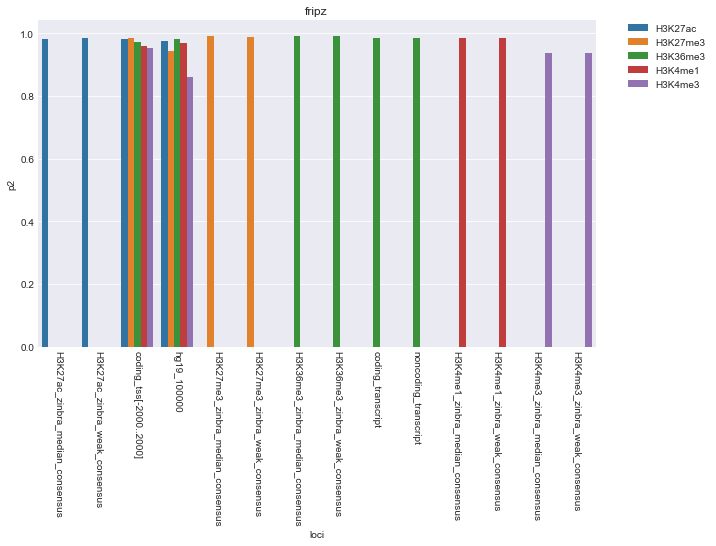

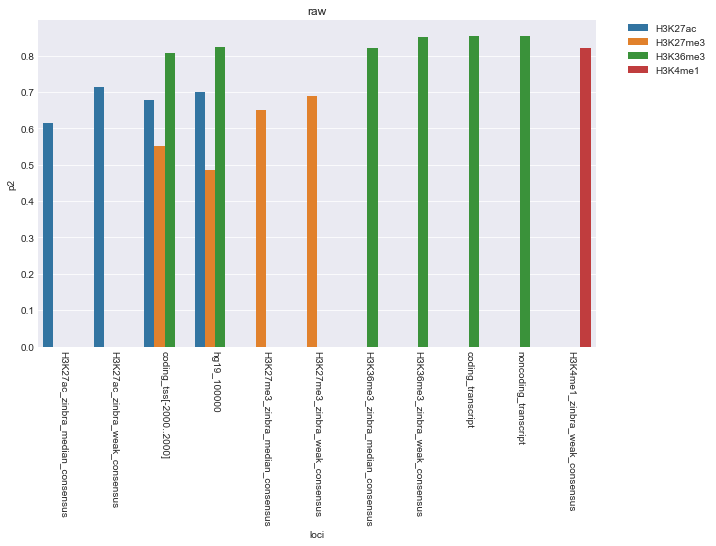

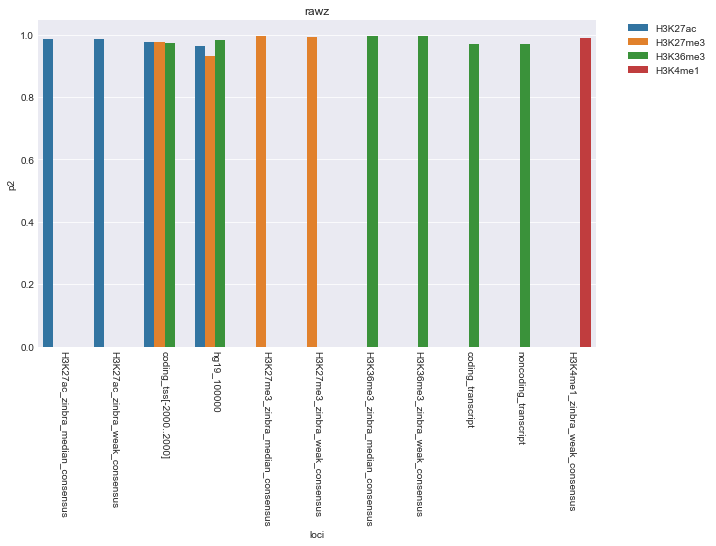

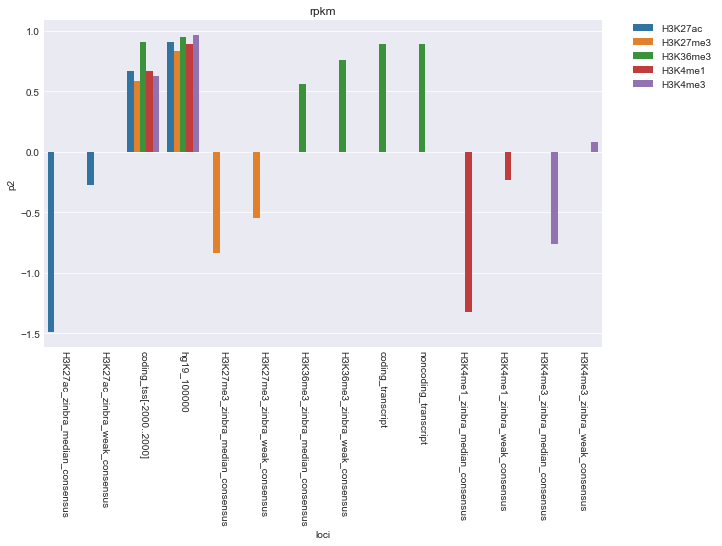

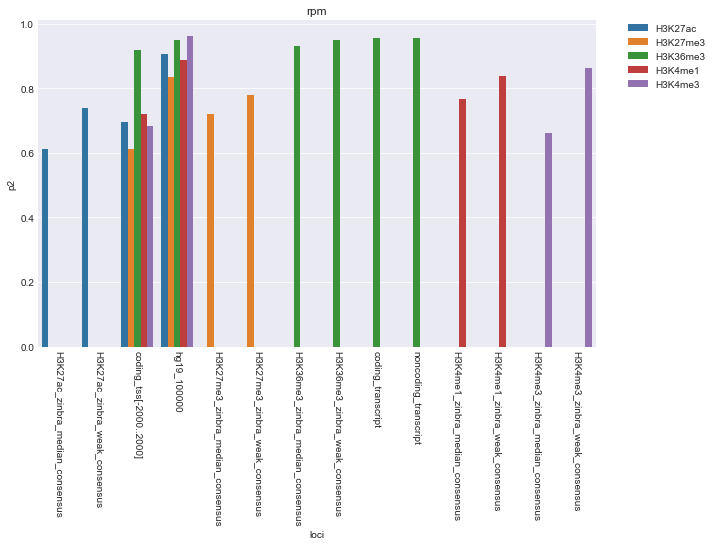

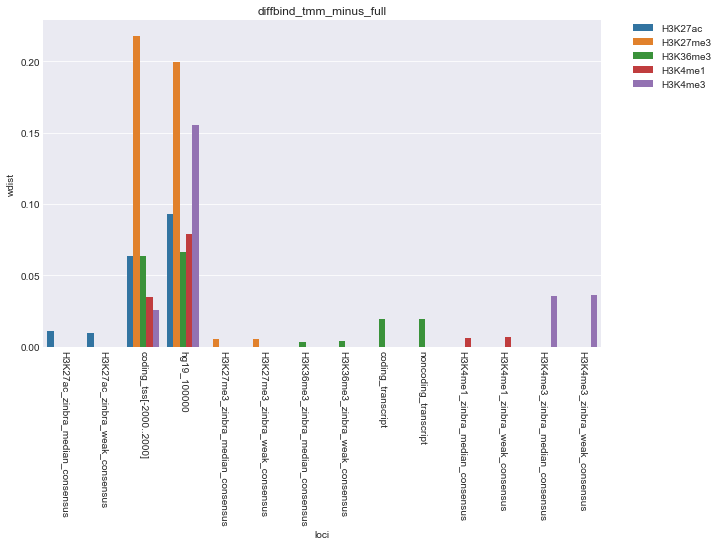

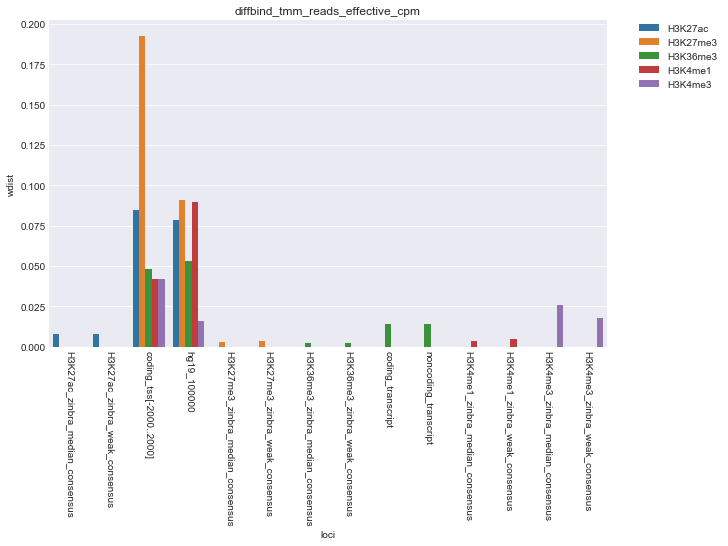

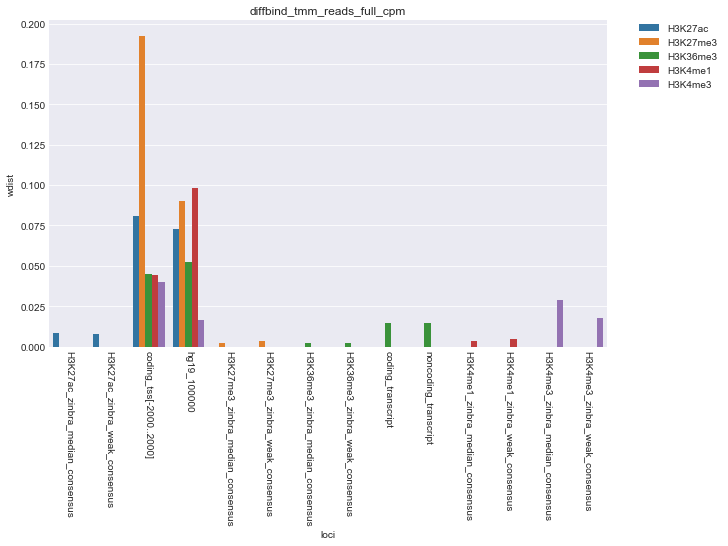

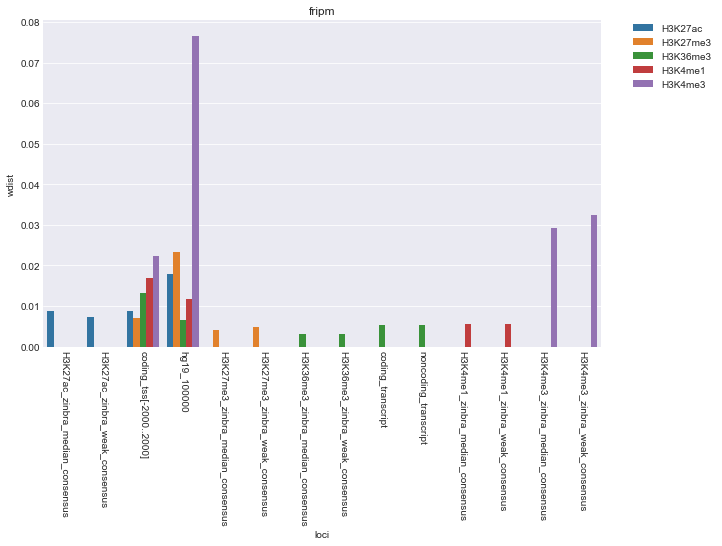

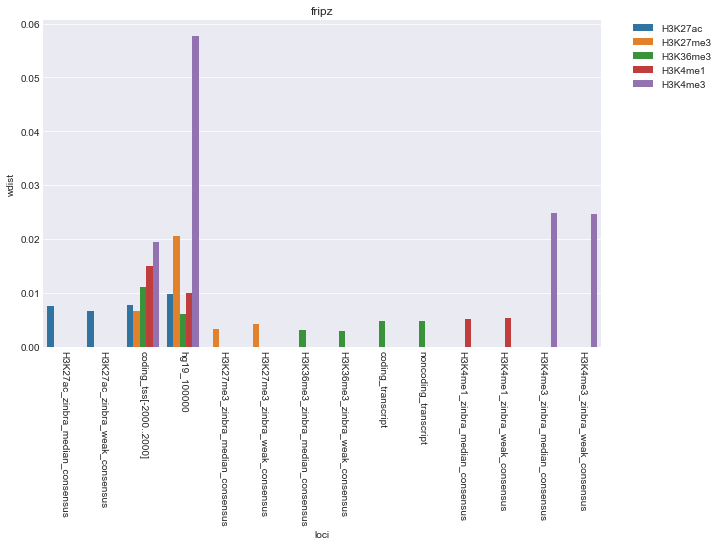

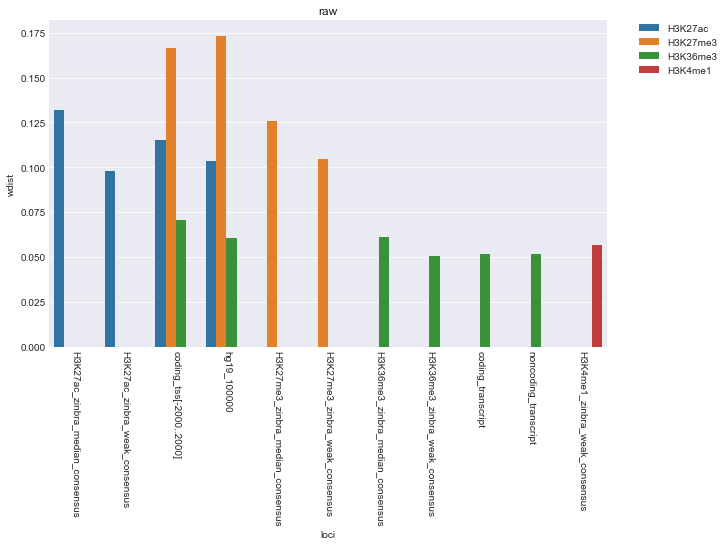

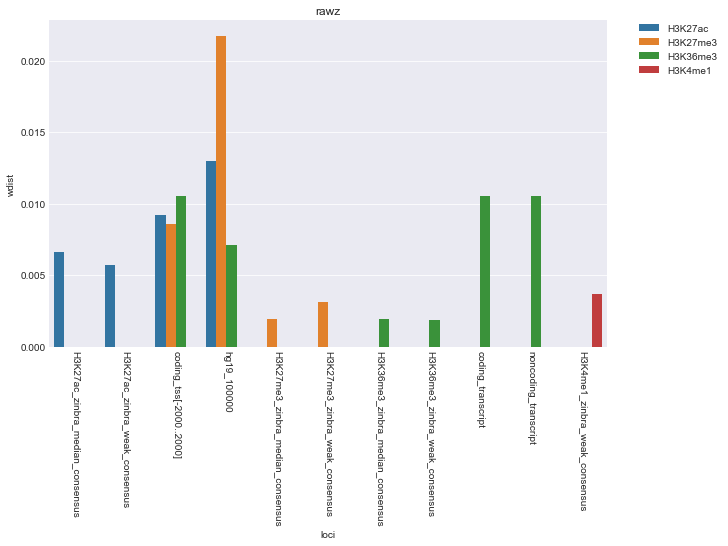

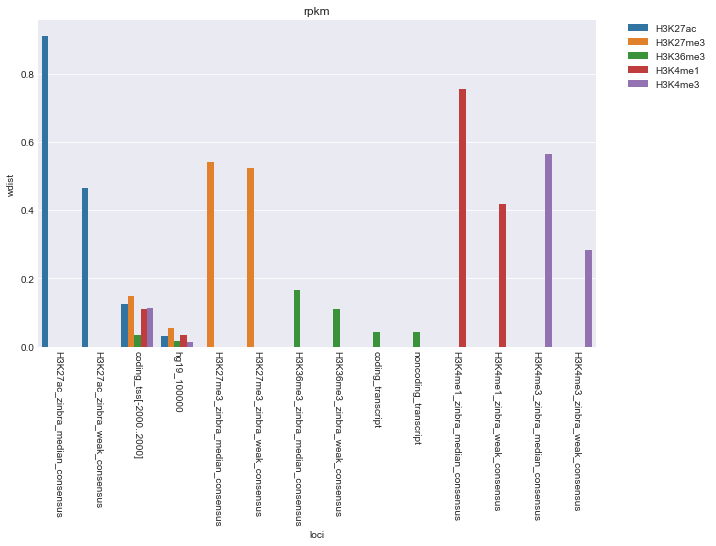

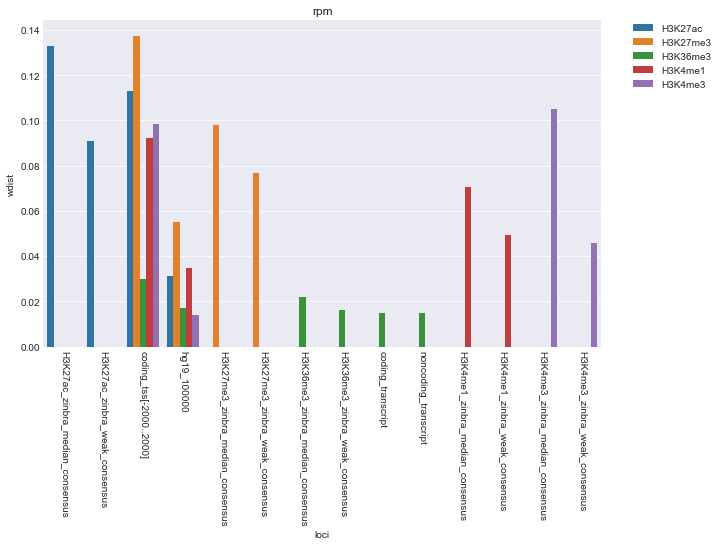

In [36]:
norms = sorted(set(df["normalization"]))
for metric in ["mean", "p2", "wdist"]:
    for norm in norms:
        plt.figure(figsize=(10,6))
        g = sns.barplot(data=df[df["normalization"] == norm], y=metric, x="loci", hue="modification")
        for item in g.get_xticklabels():
            item.set_rotation(-90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #plt.yscale("log")
        plt.title(norm)
        plt.show()

TODO: So: "rawq", "fripz" or "fripm"

# Normalizations Correlation

## Code

In [180]:
from scipy.stats import pearsonr
from collections import Counter
import re
from multiprocessing import Pool
import math
from itertools import chain

HIST_MODS = ["H3K4me1", "H3K4me3", "H3K27ac", "H3K27me3", "H3K36me3"]
def sorter_by_hist_and_donor(hist_ordering):
    def inner(label):
        # support both Y20O20 and ENCODE naming:
        # * "CD14_GSM1003562_Broad_r0_H3K36me3"
        # * "OD_OD11_H3K4me1"

        hist = hist_for(label)
        donor = label.replace("OD_", "").replace("YD_", "").replace("_" + hist, "")
        if donor.startswith("OD") or donor.startswith("YD"):
            age = donor[0:2]
            idx = int(donor[2:])
        else:
            age = "_ENCODE_"
            idx = donor
        return (hist_ordering[hist], age, idx)
    return inner

def hist_for(label):
    m = re.match("((.*_)|^)(H[0-9]+K[a-z0-9]+).*", label, re.IGNORECASE)
    return label if not m else m.groups()[2]

def color_annotator_hist(label):
    color = {'H3K4me1':'lightblue', 'H3K4me3':'red', 'H3K27ac':'black',
             'H3K27me3':'green', 'H3K36me3':'lightgray'}[hist_for(label)]

    return (("Histone", color),)

def encode_annotator(label):
    color = "mediumseagreen" if label.startswith("OD") or label.startswith("YD") else "black"
    return (("Dataset", color),)

def norms_for_loci(signals_root, loci):
    folders = []

    for dt in HIST_MODS:
        dt_root = signals_root / dt
        if dt_root.exists():
            folders.extend(f for f in walk_folders(dt_root) if f.name == loci)

    paths = [p for folder in folders for p in collect_paths(folder)]
    print("Paths: ", len(paths))
    print("Loci folders: {}".format(len(folders)), *[str(p) for p in folders], sep="\n  ")

    norm_2_paths = defaultdict(dict)
    for p in paths:
        dt = extract_datatype(p)
        norm = extract_normalization(p)
        norm_2_paths[norm][dt] = [p]
        
    return norm_2_paths

def pearson_corr_df(norm, norm_2_paths, threads):
    timeout_hours = 1
    hist_mods = HIST_MODS

    norm_paths = norm_2_paths[norm]
    print("[{}]".format(norm))
    print("    Paths:", *[str(p) for _h, p in norm_paths.items()], sep="\n      ")
    assert(set(norm_paths.keys()) == set(hist_mods))

    print("    Load data...".format(norm))
    all_cols_names = []
    all_cols = []
    for dt, paths in norm_paths.items():
        for path in paths:
            df = pd.DataFrame.from_csv(path, sep="\t", index_col=None).drop(["chr", "start", "end"], axis=1)
            fcols = [c for c in df.columns if "input" not in c.lower()]
            df = df.loc[:, fcols]
            all_cols_names.extend(df.columns)
            for i in range(0, len(df.columns)):
                all_cols.append(df.iloc[:, i])

    n = len(all_cols)
    print("    Calculating pearson correlation".format(norm))
    
    # calc pearson correlation in parallel, split caclulations in equally sized chunks
    cols_pairs = [(i, j) for i in range(0, n) for j in range(i, n)]
    chunk_size = max(1, math.ceil(len(cols_pairs) / threads))
    with Pool(processes=threads) as pool:
        multiple_results = [
            pool.apply_async(pearsonr_list, (all_cols, cols_pairs[s:s+chunk_size])) 
            for s in range(0, len(cols_pairs), chunk_size)
        ]
                                             
        values = list(chain(*[res.get(timeout=2 * timeout_hours) for res in multiple_results]))
        
        x = np.zeros((n, n), np.float32) 
        for value, (i, j) in values:
            x[i, j] = value
            x[j, i] = value

        return pd.DataFrame(data=x, columns=all_cols_names, index=all_cols_names)
    
def pearsonr_list(cols, pairs):
    return [(pearsonr(cols[i], cols[j])[0], (i, j)) for i,j in pairs]

def pearson_corr(norm, loci, norm_2_paths, pdf, threads):
    df = pearson_corr_df(norm, norm_2_paths, threads)
    
    # plot:
    hist_mods = HIST_MODS
    # sort cols: by (hist, age, donor id) where hist in order according to hist_mods.
    sorted_cols = sorted(df.columns, key=sorter_by_hist_and_donor({h:i for i, h in enumerate(hist_mods)}))
    df = df.loc[sorted_cols, sorted_cols]

    if any(not c.startswith("OD") and not c.startswith("YD") for c in df.columns):
        ann=bm.color_annotator_chain(color_annotator_hist, encode_annotator)
    else:
        ann=color_annotator_hist
    g = bm.plot_metric_heatmap("{}: Pearson Correlation for {}".format(norm, loci), df, show_or_save_plot=False, cbar=False,
                               col_color_annotator=ann, 
                               row_color_annotator=ann)

    hist_donors_cnt = Counter()
    for label in df.columns:
        hist = hist_for(label)
        hist_donors_cnt[hist] += 1
        
    hist_donors_counts = [hist_donors_cnt[h] for h in hist_mods]

    ticks = [sum(hist_donors_counts[0:k]) + hist_donors_counts[k]/2 for k in range(len(hist_donors_counts))]
    g.ax_heatmap.set_xticks(ticks)
    g.ax_heatmap.set_xticklabels(hist_mods, rotation="horizontal", horizontalalignment = 'center')
    g.ax_heatmap.set_yticks(ticks)
    g.ax_heatmap.set_yticklabels(hist_mods, rotation="vertical", verticalalignment = 'center')

    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=90)

    # Turn off annotations
    #g.ax_col_colors.set_yticks([])
    g.ax_row_colors.set_xticks([])

    #bm.save_plot(plot_path)
    if pdf:
        pdf.savefig()
    plt.show()
    plt.close()

In [ ]:
import traceback
def process_pearson_corr(signals_root, loci, threads, prefix="pearson_"):
    norm_2_paths = norms_for_loci(signals_root, loci)
    for norm in sorted(list(norm_2_paths.keys())):
        try:
            res_path = str(signals_root / "{}{}_{}.pdf".format(prefix, loci, norm))
            with PdfPages(res_path) as pdf:
                pearson_corr(norm, loci, norm_2_paths, pdf, threads)
            print("Saved: ", res_path)

        except Exception as e:
            print("Failed:", norm, e)
            traceback.print_exc()
            #raise

## Y20O20

Paths:  41
Loci folders: 5
  /mnt/stripe/bio/experiments/signal_experiment/H3K4me1/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K4me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K27ac/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K27me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/hg19_100000
[raw]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment/H3K4me1/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment/H3K4me3/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment/H3K27ac/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment/H3K27me3/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/hg19_100000/hg19_100000_raw.tsv
    Load data...
    Calculating pearson correlation


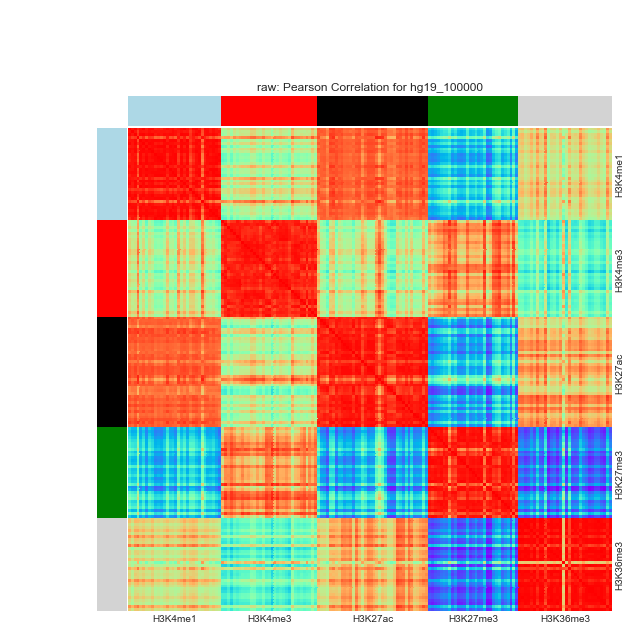

Saved:  /mnt/stripe/bio/experiments/signal_experiment/pearson_y20o20_hg19_100000_raw.pdf


In [125]:
process_pearson_corr(Path("/mnt/stripe/bio/experiments/signal_experiment"), "hg19_100000", 
                     threads, "pearson_y20o20_")

In [ ]:
process_pearson_corr(Path("/mnt/stripe/bio/experiments/signal_experiment"), "hg19_1000", 
                     threads, "pearson_y20o20_")

## Encode

Paths:  45
Loci folders: 5
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000
[raw]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_raw.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_raw.tsv
    Load data...
    Calculating pearson c

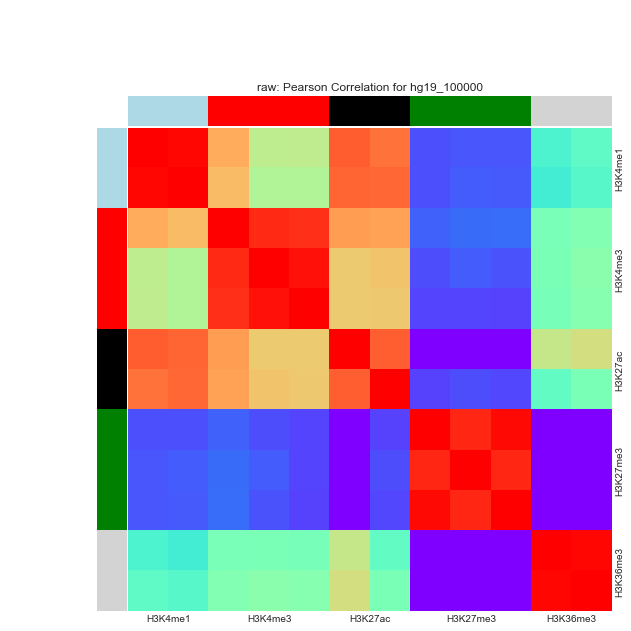

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_raw.pdf
[fripm]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_fripm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_fripm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_fripm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_fripm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_fripm.tsv
    Load data...
    Calculating pearson correlation


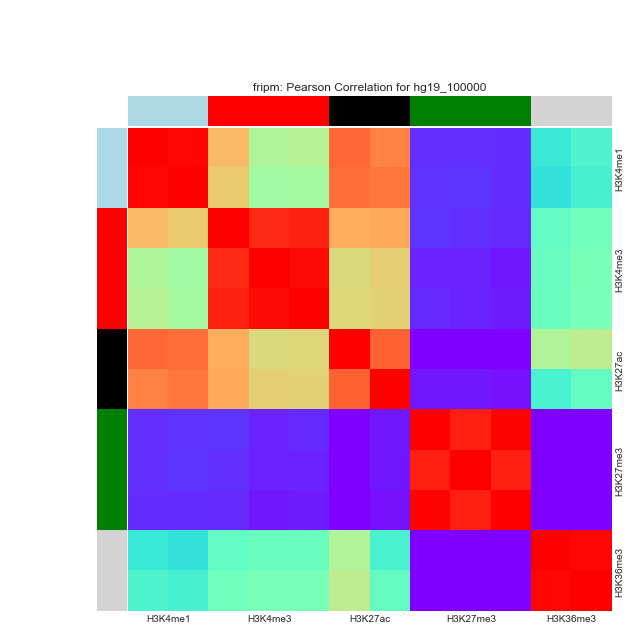

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_fripm.pdf
[rpm]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_rpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_rpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_rpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_rpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_rpm.tsv
    Load data...
    Calculating pearson correlation


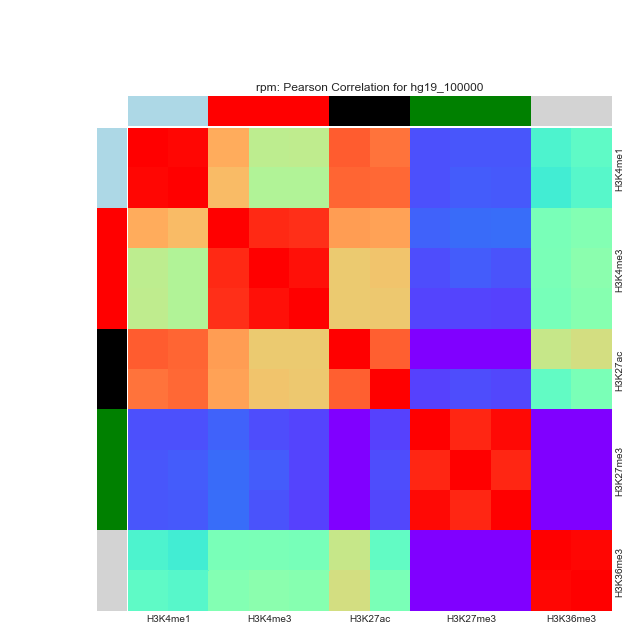

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_rpm.pdf
[diffbind_tmm_minus_full]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_diffbind_tmm_minus_full.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_diffbind_tmm_minus_full.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_diffbind_tmm_minus_full.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_diffbind_tmm_minus_full.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_diffbind_tmm_minus_full.tsv
    Load data...
    Calculating pearson correlation


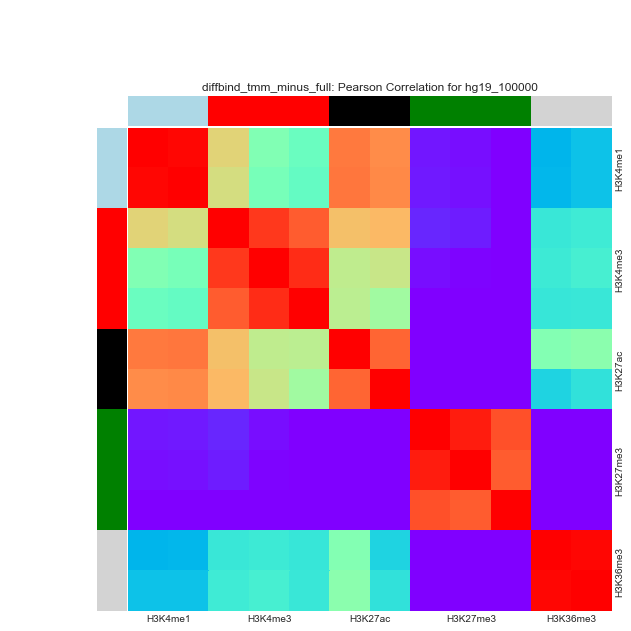

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_diffbind_tmm_minus_full.pdf
[diffbind_tmm_reads_full_cpm]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv
    Load data...
    Calculating pearson correlation


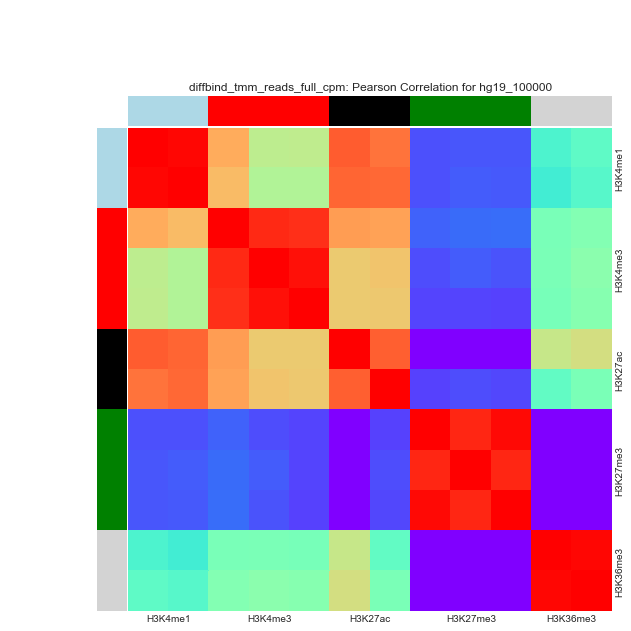

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_diffbind_tmm_reads_full_cpm.pdf
[fripz]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_fripz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_fripz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_fripz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_fripz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_fripz.tsv
    Load data...
    Calculating pearson correlation


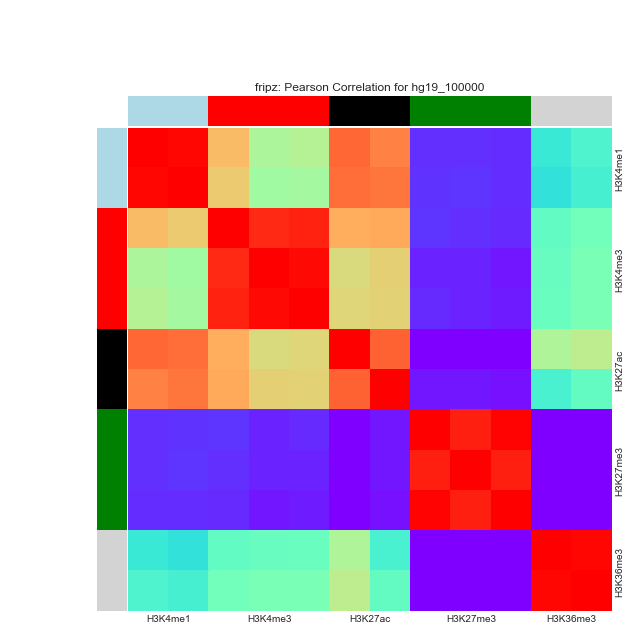

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_fripz.pdf
[diffbind_tmm_reads_effective_cpm]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_diffbind_tmm_reads_effective_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_effective_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_diffbind_tmm_reads_effective_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_effective_cpm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_effective_cpm.tsv
    Load data...
    Calculating pearson correlation


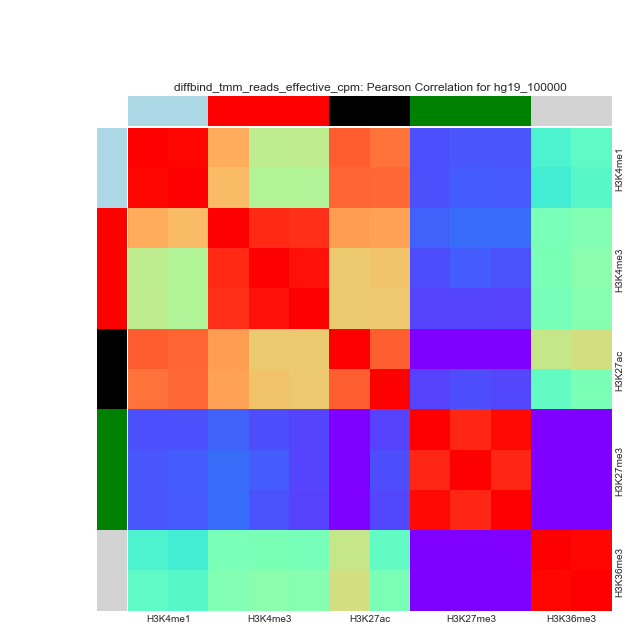

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_diffbind_tmm_reads_effective_cpm.pdf
[rawz]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_rawz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_rawz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_rawz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_rawz.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_rawz.tsv
    Load data...
    Calculating pearson correlation


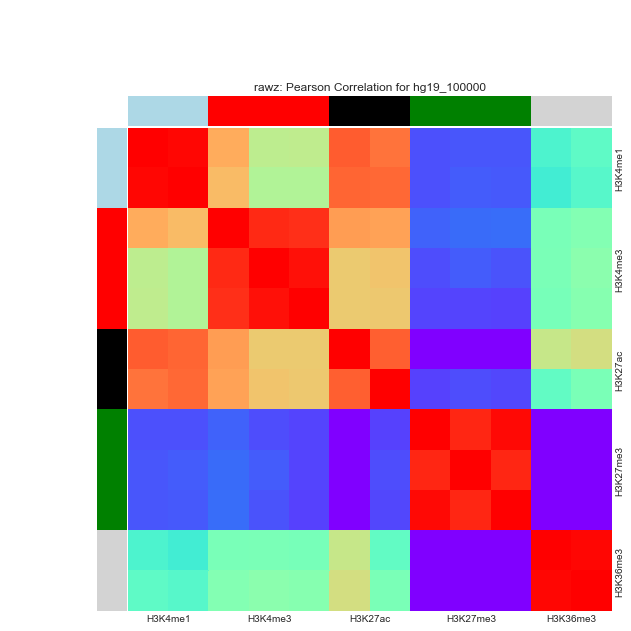

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_rawz.pdf
[rpkm]
    Paths:
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_rpkm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_rpkm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_rpkm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000/hg19_100000_rpkm.tsv
      /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000/hg19_100000_rpkm.tsv
    Load data...
    Calculating pearson correlation


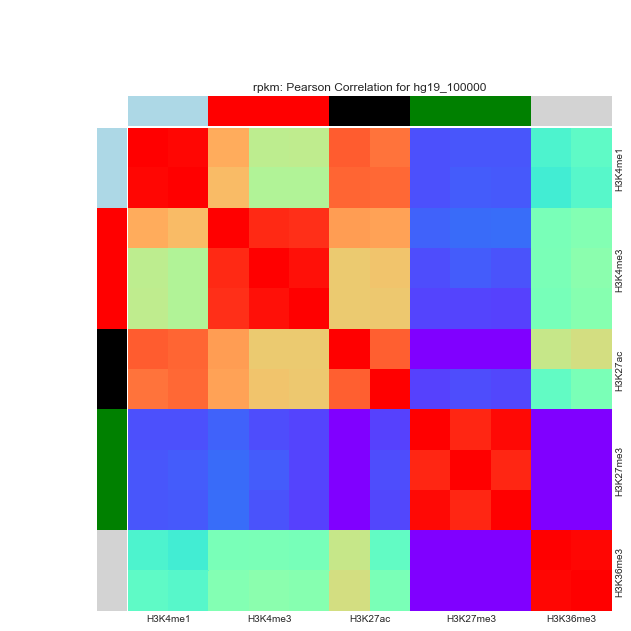

Saved:  /mnt/stripe/bio/experiments/signal_experiment_encode/pearson_encode_hg19_100000_rpkm.pdf


In [135]:
process_pearson_corr(Path("/mnt/stripe/bio/experiments/signal_experiment_encode"), "hg19_100000", 
                     threads, "pearson_encode_")

In [ ]:
process_pearson_corr(Path("/mnt/stripe/bio/experiments/signal_experiment_encode"), "hg19_1000", 
                     threads, "pearson_encode_")

## Y20O20 + Encode: 100k

In [183]:
import traceback
def process_enc_aging_pearson_corr(loci, threads):
    encode_norm_2_paths = norms_for_loci(Path("/mnt/stripe/bio/experiments/signal_experiment_encode"), loci)
    y20od20_norm_2_paths = norms_for_loci(Path("/mnt/stripe/bio/experiments/signal_experiment"), loci)

    for norm in sorted(list(y20od20_norm_2_paths.keys())):
        if norm not in encode_norm_2_paths:
            print("No {} for ENCODE".format(norm))

        if set(HIST_MODS) !=  set(y20od20_norm_2_paths[norm]):
            print("[{}]: Y20O20 missed hist modes, available only {}".format(
                norm, sorted(list(y20od20_norm_2_paths[norm].keys()))
            ))
            continue

        if set(HIST_MODS) !=  set(encode_norm_2_paths[norm]):
            print("[{}]: ENCODE missed hist modes, available only {}".format(
                norm, sorted(list(encode_norm_2_paths[norm].keys()))
            ))
            continue

        try:
            res_path = str(signals_root / "pearson_enc_vs_y20o20_{}_{}.pdf".format(loci, norm))
            with PdfPages(res_path) as pdf:
                pearson_corr(norm, loci, 
                             {norm: {h: y20od20_norm_2_paths[norm][h] + encode_norm_2_paths[norm][h] for h in HIST_MODS}},
                             None, threads)
            print("Saved: ", res_path)

        except Exception as e:
            print("Failed:", norm, e)
            traceback.print_exc()
            #raise

Paths:  45
Loci folders: 5
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K27me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment_encode/H3K36me3/150/hg19_100000
Paths:  41
Loci folders: 5
  /mnt/stripe/bio/experiments/signal_experiment/H3K4me1/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K4me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K27ac/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K27me3/150/hg19_100000
  /mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/hg19_100000
[diffbind_tmm_minus_full]: Y20O20 missed hist modes, available only ['H3K27ac']
[diffbind_tmm_reads_effective_cpm]
    Paths:
      [PosixPath('/mnt/stripe/bio/experiments/signal_experime

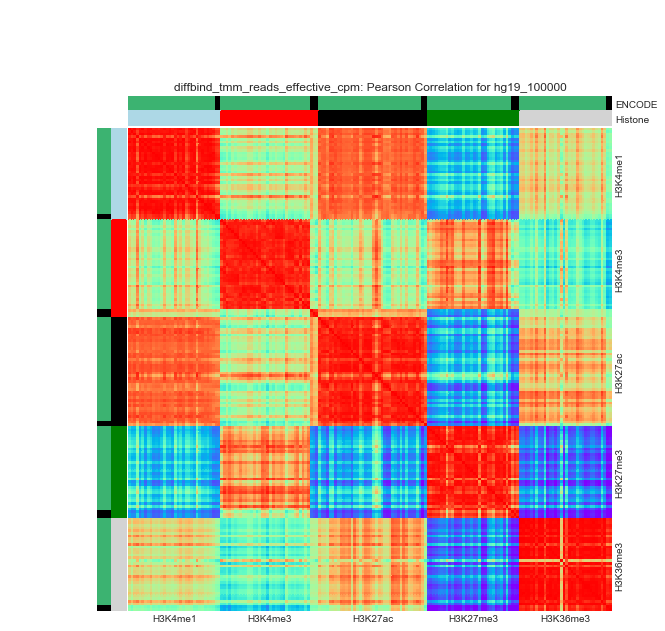

Saved:  /mnt/stripe/bio/experiments/signal_experiment/pearson_enc_vs_y20o20_hg19_100000_diffbind_tmm_reads_effective_cpm.pdf
[diffbind_tmm_reads_full_cpm]
    Paths:
      [PosixPath('/mnt/stripe/bio/experiments/signal_experiment/H3K4me1/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv'), PosixPath('/mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me1/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv')]
      [PosixPath('/mnt/stripe/bio/experiments/signal_experiment/H3K4me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv'), PosixPath('/mnt/stripe/bio/experiments/signal_experiment_encode/H3K4me3/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv')]
      [PosixPath('/mnt/stripe/bio/experiments/signal_experiment/H3K27ac/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv'), PosixPath('/mnt/stripe/bio/experiments/signal_experiment_encode/H3K27ac/150/hg19_100000/hg19_100000_diffbind_tmm_reads_full_cpm.tsv')]
      [PosixPath('/mnt/s

KeyboardInterrupt: 

In [184]:
process_enc_aging_pearson_corr("hg19_100000", threads)

In [ ]:
process_enc_aging_pearson_corr("hg19_1000", threads)

# H3K27me3 + DiffBind scores options

In [3]:
signals_root = Path("/mnt/stripe/bio/experiments/k27me3@dmrs")
paths = [p for p in signals_root.glob("k*_counts.csv")]
[p.name for p in paths]

['k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_READS_FOLD_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_RPKM_FOLD_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_READS_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_READS_MINUS_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_RPKM_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_READS_FULL_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_READS_EFFECTIVE_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_EFFECTIVE_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_READS_FULL_CPM_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_READS_EFFECTIVE_CPM_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_CPM_counts.csv',
 'k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_EFFECTIVE_CPM_counts.csv',
 'k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_READS_counts.csv',
 'k27me3@dmrs_dedup_FALSE_f_125_DBA_S

In [4]:
output_path = signals_root / "validate.norms.permutation_r2.{}.csv".format(simulations)
output_path

print(str(output_path), "[exists]" if output_path.exists() else "[not exists]")

/mnt/stripe/bio/experiments/k27me3@dmrs/validate.norms.permutation_r2.100001.csv [not exists]


In [5]:
if not output_path.exists():
    process(paths, str(output_path), seed=100, simulations=simulations, threads=threads)
print("Results file: ", str(output_path))

--- [1 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_READS_FOLD_counts.csv
mean = 0.876946308073584, median = 0.9088608299331994, [min, max] = [-0.6532947644833222, 0.9795135330213498], [2%, 5%, 10%, 98%] = [0.4584483107903483, 0.6828700950570556, 0.7851950035352563, 0.9687738570345481], wd = 0.17905376944049356
--- [2 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_RPKM_FOLD_counts.csv
mean = 0.8688935854629128, median = 0.9023408095396481, [min, max] = [-0.6160764886591312, 0.9780828440443476], [2%, 5%, 10%, 98%] = [0.49067264316327575, 0.6549551850351405, 0.7585683238152774, 0.9667490676250501], wd = 0.18526205296152698
--- [3 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_TRUE_f_125_DBA_SCORE_READS_counts.csv
mean = 0.8718365487035007, median = 0.9320045721908288, [min, max] = [-1.0104674088598644, 0.9852211038889295], [2%, 5%, 

--- [23 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_READS_FULL_CPM_counts.csv
mean = 0.9156919786970041, median = 0.93934056591928, [min, max] = [-0.11939059322216061, 0.9835914417632508], [2%, 5%, 10%, 98%] = [0.6351937323273174, 0.7748663295204686, 0.8480070364706274, 0.976695288302062], wd = 0.12400814622167142
--- [24 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_READS_EFFECTIVE_CPM_counts.csv
mean = 0.9093661669246393, median = 0.9379368020532315, [min, max] = [-0.09869339835393776, 0.9842582901099755], [2%, 5%, 10%, 98%] = [0.5390631170681599, 0.7453570236988438, 0.8283756531223282, 0.9769876743079315], wd = 0.1376815840645988
--- [25 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_MINUS_FULL_CPM_counts.csv
mean = 0.7294494312666161, median = 0.8908991050393528, [min, max] = [-5.587617445

--- [45 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_FALSE_f_150_DBA_SCORE_TMM_READS_FULL_counts.csv
mean = 0.9209869537853221, median = 0.9422552416895763, [min, max] = [0.22693558659664015, 0.9849794430741793], [2%, 5%, 10%, 98%] = [0.6375666893024712, 0.789631180773567, 0.853039602996769, 0.9774566455986243], wd = 0.11163406781406798
--- [46 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_FALSE_f_150_DBA_SCORE_TMM_READS_EFFECTIVE_counts.csv
mean = 0.9266898847353843, median = 0.943623902483868, [min, max] = [0.30616573070880504, 0.9840916693233119], [2%, 5%, 10%, 98%] = [0.7078174637907396, 0.8196486329716435, 0.8699622668814232, 0.9775953804102011], wd = 0.09796278791973943
--- [47 / 52] -----------
Process: /mnt/stripe/bio/experiments/k27me3@dmrs/k27me3@dmrs_dedup_FALSE_f_150_DBA_SCORE_TMM_MINUS_FULL_counts.csv
mean = 0.865592712952894, median = 0.9144034850974434, [min, max] = [-1.0030437160126255, 0.980

In [6]:
df = pd.DataFrame.from_csv(output_path, index_col=None)
df["loci"] = [Path(f).name for f in df["file"]]
print("Shape:", df.shape)
df

Shape: (52, 10)


,modification,file,normalization,mean,median,p2,p5,p10,wdist,loci
0,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_READS_...,0.770878,0.877605,-0.675002,0.368827,0.594785,0.469302,k27me3@dmrs
1,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_READS_...,0.670177,0.878432,-2.073086,0.005428,0.481444,0.897649,k27me3@dmrs
2,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_READS_...,0.708741,0.891389,-1.602075,0.062038,0.510546,0.777798,k27me3@dmrs
3,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_RPKM_F...,0.826861,0.894437,0.049478,0.489265,0.685384,0.306457,k27me3@dmrs
4,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_RPKM_c...,0.865235,0.916058,0.326646,0.599364,0.760130,0.234358,k27me3@dmrs
5,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_MI...,0.722658,0.893418,-1.354451,0.200071,0.533169,0.732499,k27me3@dmrs
6,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_MI...,0.722680,0.893418,-1.354451,0.200071,0.534081,0.732460,k27me3@dmrs
7,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_MI...,0.729449,0.890899,-1.440169,0.222112,0.554398,0.681763,k27me3@dmrs
8,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_MI...,0.729447,0.890899,-1.440169,0.222112,0.554398,0.681763,k27me3@dmrs
9,NaN,/mnt/stripe/bio/experiments/k27me3@dmrs,k27me3@dmrs_dedup_FALSE_f_125_DBA_SCORE_TMM_RE...,0.909366,0.937937,0.539063,0.745357,0.828376,0.137682,k27me3@dmrs
